In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional

import dca
import evo_weight_tools

import dataloader

In [2]:
CODON_MAP = dataloader.codon_map
qc = len(CODON_MAP) # qc = 61


AA_MAP =  dataloader.AA_map_str.copy()
if '-' in AA_MAP:
    del AA_MAP['-']
qa = len(AA_MAP) # qa = 20
INV_AA_MAP = {v:k for k,v in AA_MAP.items()}


#CODON_AA_MAP
CODON_AA_MAP = np.array([AA_MAP[dataloader.codon_table.forward_table[c]] for 
                         c, idx in CODON_MAP.items()], dtype=np.int)
CODON_AA_MAP = torch.from_numpy(CODON_AA_MAP)

# Binary matrix that translates between Codon index and Amino Acid index
codon_aa_mat = torch.eye(len(AA_MAP))[CODON_AA_MAP].float() # shape (qc, qa) binary

In [3]:
def load_msa(filename):
    ret = evo_weight_tools.get_codon_msa_as_int_array(filename, dataloader.codon_map)
    return torch.ByteTensor(ret)

def load_log_proposal(filename):
    return torch.FloatTensor(np.load(filename))

def load_msa_and_log_proposal(round_num):
    msa_round = load_msa(f"./data_test/Round{round_num}_Q15_C10_nts.aln.gz")
    log_proposal_round = load_log_proposal(f"./data_test/Round{round_num}_weights.npy")
    return msa_round, log_proposal_round

In [4]:
# Load all the MSAs (pytorch ints) and evo weights (floats) 
# and concatenate them together
msa_proposal_zip = zip(*map(load_msa_and_log_proposal, [1,2]))
msa_int = torch.cat(next(msa_proposal_zip))
log_proposal = torch.cat(next(msa_proposal_zip))
del(msa_proposal_zip)
L = msa_int.shape[1]
print(f"Length of sequences: {L}")
print(f"MSA shape: {msa_int.shape}")
print(f"Log Proposal shape: {log_proposal.shape}")

Length of sequences: 186
MSA shape: torch.Size([19973, 186])
Log Proposal shape: torch.Size([19973, 186, 61])


In [5]:
with torch.no_grad():
    msa_one_hot = torch.nn.functional.one_hot(msa_int.long(), qc).float()
    weights = torch.ones(msa_one_hot.shape[0], dtype=torch.float)
    msa_cat = msa_one_hot.argmax(dim=2) # should be the same as msa_int now

In [6]:
class EvoDCA(dca.DCA):
    
    def forward(self, x, x_log_proposal):
        """`x` is a one-hot encoded MSA (or subset of an MSA) Shape: (n, L, q)
           `x_log_proposal` is the weights computed by evo_weight_tools Shape: (n, L, q)
        """
        x_msa = x
        w_eye = self.w * self.weights_eye
        self.weights = w_eye + w_eye.permute(2,3,0,1)
        
        # convert weights and biases to codon level params
        weights_codon = self.weights.index_select(1, 
                                CODON_AA_MAP).index_select(3, CODON_AA_MAP)
        bias_codon = self.bias.index_select(1, CODON_AA_MAP)
        
        # calculate logits with codon params and add in log_proposal
        x_logit = torch.tensordot(x_msa, weights_codon, 2) + bias_codon + x_log_proposal
        return x_logit



In [7]:
pseudo_count = 0.01 

with torch.no_grad():
    b_ini = torch.matmul(msa_one_hot.float(), codon_aa_mat) + pseudo_count
    b_ini = torch.log(b_ini.mean(0))
    model = EvoDCA(ncol=L, 
                   ncat=qa, # Initialize DCA model with number of amino acids and not
                            # number of codons as that is the shape of our params
                   Neff=1e4, # ??Not sure what we should set this to
                   b_ini = b_ini)


In [8]:
learning_rate = 0.01
num_epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model.train() # sets model to TRAIN mode

EvoDCA()

In [9]:
losses = np.zeros(num_epochs, dtype=np.double)

loss_fn = EvoDCA.create_loss_function()
for epoch in range(num_epochs):
    x_logit = model(msa_one_hot, log_proposal)
    loss = loss_fn(x_logit=x_logit, x_cat=msa_cat, 
                   x_weights=weights, model=model)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    losses[epoch] = loss.item()
    print(f"Epoch {epoch}, loss: {loss:.2f}")


Epoch 0, loss: 53.52
Epoch 1, loss: 463.49
Epoch 2, loss: 54.39
Epoch 3, loss: 59.90
Epoch 4, loss: 68.31
Epoch 5, loss: 74.66
Epoch 6, loss: 79.58
Epoch 7, loss: 84.18
Epoch 8, loss: 88.61
Epoch 9, loss: 92.30


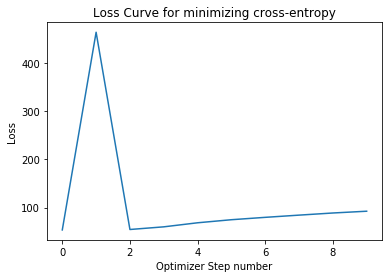

In [10]:
plt.plot(losses)
plt.title("Loss Curve for minimizing cross-entropy")
plt.xlabel("Optimizer Step number")
plt.ylabel("Loss");